In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



Load the dataset and examine it. Let's see what we are working with. 

Input i/o

In [37]:
#uncomment the following line if you want to manually input file name
#retail = pd.read_csv(input("Enter your filename:"), encoding = 'unicode_escape')
retail = pd.read_csv('/content/drive/MyDrive/OnlineRetail.csv', encoding = 'unicode_escape')
retail.head()

,ï»¿InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


## Preparing the Data

We need to clean up the data a little bit. 
Some of the descriptions have spaces that need to be removed. We’ll also drop the rows that don’t have invoice numbers and remove the credit transactions 
(those with invoice numbers containing C).

Change "ï»¿InvoiceNo" Column Head to "Invoice" as well. 

In [11]:
retail['Description'] = retail['Description'].str.strip()
retail.dropna(axis=0, subset=['ï»¿InvoiceNo'], inplace=True)
retail['InvoiceNo'] = retail['ï»¿InvoiceNo'].astype('str')
retail = retail[~retail['InvoiceNo'].str.contains('C')]


After the cleanup, we need to consolidate the items into 1 transaction per row with each product 1 hot encoded. For the sake of keeping the data set small, I’m only looking at sales for France. However, in additional code below, I will compare these results to sales from Germany. Further country comparisons would be interesting to investigate.

In [12]:
basket = (retail[retail['Country'] =="France"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

In [13]:
basket.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There are a lot of zeros in the data but we also need to make sure any positive values are converted to a 1 and anything less the 0 is set to 0.Just to make sure.  This step will complete the one hot encoding of the data and remove the postage column (since that charge is not one we wish to explore):

In [14]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)

In [15]:
'''
Generate Frequent Itemsets
Now that the data is structured properly, we can generate frequent item sets 
that have a support of at least 7% (this number was chosen after many tests like .1, .2, .5):
'''
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)

In [16]:
'''Building Association Rules Using Frequent Itemset
The final step is to generate the rules with their corresponding support, confidence and lift:
'''


rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.096939,0.102041,0.073980,0.763158,7.478947,0.064088,3.791383
1,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.102041,0.096939,0.073980,0.725000,7.478947,0.064088,3.283859
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.096939,0.094388,0.079082,0.815789,8.642959,0.069932,4.916181
3,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.094388,0.096939,0.079082,0.837838,8.642959,0.069932,5.568878
4,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE PINK),0.094388,0.102041,0.073980,0.783784,7.681081,0.064348,4.153061


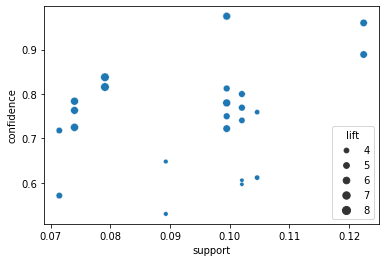

In [17]:
# Import seaborn under its standard alias
import seaborn as sns
import matplotlib.pyplot as plt


# Generate scatterplot using support and confidence
sns.scatterplot(x = "support", y = "confidence", 
                size = "lift", data = rules)
plt.show()

In [18]:
#We can filter the dataframe using standard pandas code. In this case, look for a large lift (6) and high confidence (.8):
#I am only interested in high confidence and high lift

rules[ (rules['lift'] >= 6) &
       (rules['confidence'] >= 0.8) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.096939,0.094388,0.079082,0.815789,8.642959,0.069932,4.916181
3,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.094388,0.096939,0.079082,0.837838,8.642959,0.069932,5.568878
17,(SET/6 RED SPOTTY PAPER PLATES),(SET/20 RED RETROSPOT PAPER NAPKINS),0.127551,0.132653,0.102041,0.800000,6.030769,0.085121,4.336735
18,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.137755,0.127551,0.122449,0.888889,6.968889,0.104878,7.852041
19,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.127551,0.137755,0.122449,0.960000,6.968889,0.104878,21.556122
20,"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",(SET/6 RED SPOTTY PAPER PLATES),0.102041,0.127551,0.099490,0.975000,7.644000,0.086474,34.897959
21,"(SET/6 RED SPOTTY PAPER CUPS, SET/6 RED SPOTTY...",(SET/20 RED RETROSPOT PAPER NAPKINS),0.122449,0.132653,0.099490,0.812500,6.125000,0.083247,4.625850
22,"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...",(SET/6 RED SPOTTY PAPER CUPS),0.102041,0.137755,0.099490,0.975000,7.077778,0.085433,34.489796


In [19]:
#The most sold products we get are Alarm clock bakelike green and alarm clock bakelike red 
print("ALARM CLOCK BAKELIKE GREEN : ",basket['ALARM CLOCK BAKELIKE GREEN'].sum())
print("ALARM CLOCK BAKELIKE RED : ",basket['ALARM CLOCK BAKELIKE RED'].sum())

ALARM CLOCK BAKELIKE GREEN :  340.0
ALARM CLOCK BAKELIKE RED :  316.0


For instance, we can see that we sell 340 Green Alarm clocks and 316 Red Alarm Clocks. 
Very close. 

Let's check for United Kingdom. Same logic as previous. 

In [27]:
basket2 = (retail[retail['Country'] =="United Kingdom"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))


basket2.head()

Description,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,wrongly coded 20713,wrongly coded 23343,wrongly coded-23343,wrongly marked,wrongly marked 23343,wrongly marked carton 22804,wrongly marked. 23343 in box,wrongly sold (22719) barcode,wrongly sold as sets,wrongly sold sets
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


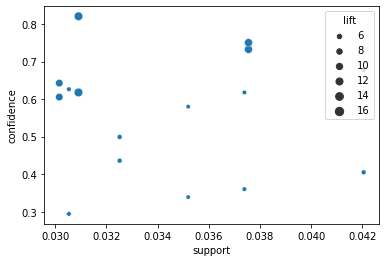

In [28]:

basket_sets2 = basket2.applymap(encode_units)
basket_sets2.drop('POSTAGE', inplace=True, axis=1)
frequent_itemsets2 = apriori(basket_sets2, min_support=0.03, use_colnames=True) #anything above 0.3 doesnt produce rules 
rules2 = association_rules(frequent_itemsets2, metric="lift", min_threshold=1)


# Import seaborn under its standard alias
import seaborn as sns
import matplotlib.pyplot as plt


# Generate scatterplot using support and confidence
sns.scatterplot(x = "support", y = "confidence", 
                size = "lift", data = rules2)
plt.show()

In [29]:
rules2[ (rules2['lift'] >= 4) &
        (rules2['confidence'] >= 0.5)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.046925,0.049818,0.030159,0.642694,12.900874,0.027821,2.659296
1,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.049818,0.046925,0.030159,0.605376,12.900874,0.027821,2.415149
2,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.037658,0.050032,0.030909,0.820768,16.404818,0.029024,5.300218
3,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.050032,0.037658,0.030909,0.617773,16.404818,0.029024,2.517724
4,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.051264,0.050032,0.037551,0.732497,14.640537,0.034986,3.551247
5,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.050032,0.051264,0.037551,0.750535,14.640537,0.034986,3.803087
6,(JUMBO BAG BAROQUE BLACK WHITE),(JUMBO BAG RED RETROSPOT),0.048747,0.103814,0.030534,0.626374,6.033613,0.025473,2.398615
8,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.062085,0.103814,0.042051,0.677308,6.524245,0.035605,2.777218
10,(JUMBO SHOPPER VINTAGE RED PAISLEY),(JUMBO BAG RED RETROSPOT),0.060692,0.103814,0.035194,0.579876,5.585724,0.028893,2.133149
12,(JUMBO STORAGE BAG SUKI),(JUMBO BAG RED RETROSPOT),0.060531,0.103814,0.037390,0.617699,5.950055,0.031106,2.344190


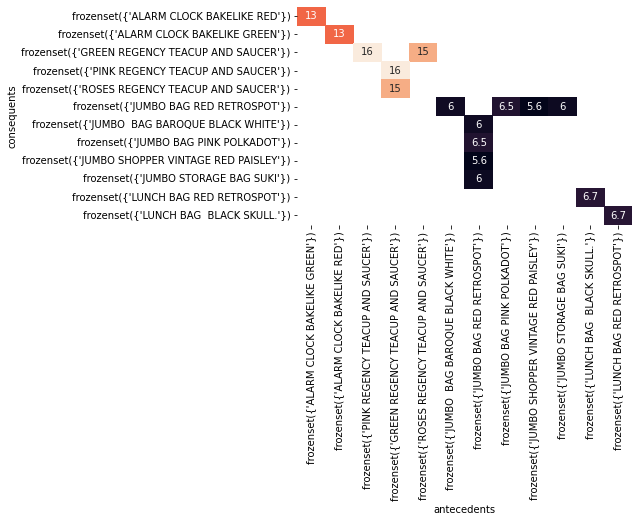

In [30]:
# let's generate a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Transform the DataFrame of rules into a matrix using the lift metric

pivot = rules2.pivot(index = 'consequents', columns = 'antecedents', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off

sns.heatmap(pivot, annot = True, cbar=False)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

# For France: 

In [32]:
basket3 = (retail[retail['Country'] =="Germany"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))


basket3.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,...,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
basket_sets3 = basket3.applymap(encode_units)
basket_sets3.drop('POSTAGE', inplace=True, axis=1)
frequent_itemsets3 = apriori(basket_sets3, min_support=0.05, use_colnames=True)
rules2 = association_rules(frequent_itemsets3, metric="lift", min_threshold=1)

In [34]:
rules2[ (rules2['lift'] >= 4) &
        (rules2['confidence'] >= 0.5)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN WOODLAND ANIMALS),0.115974,0.137856,0.067834,0.584906,4.242887,0.051846,2.076984
6,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.107221,0.137856,0.061269,0.571429,4.145125,0.046488,2.011670
11,(RED RETROSPOT CHARLOTTE BAG),(WOODLAND CHARLOTTE BAG),0.070022,0.126915,0.059081,0.843750,6.648168,0.050194,5.587746


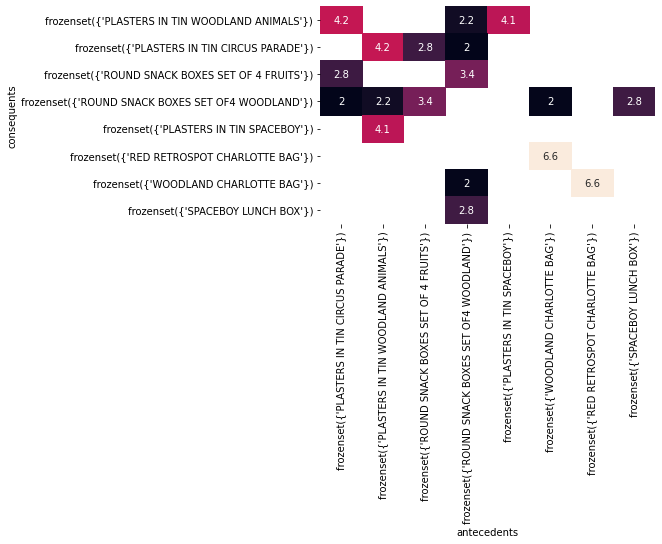

In [35]:
# Import seaborn under its standard alias
import seaborn as sns
import matplotlib.pyplot as plt

# Transform the DataFrame of rules into a matrix using the lift metric

pivot = rules2.pivot(index = 'consequents', columns = 'antecedents', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off

sns.heatmap(pivot, annot = True, cbar=False)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()